In [1]:
import tensorflow as tf

C:\Users\other\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

class CifarLoader(object):
    def __init__(self, source_files):
        self._source = source_files
        self._i = 0
        self.images = None
        self.labels = None
        
    def load(self):
        data = [unpickle(f) for f in self._source]
        # print(data)
        images = np.vstack([d[b"data"] for d in data])
        n = len(images)
        self.images = images.reshape(n, 3, 32, 32).transpose(0, 2, 3, 1).astype(float) / 255
        self.labels = one_hot(np.hstack([d[b"labels"] for d in data]), 10)
        return self
    
    def next_batch(self, batch_size):
        x, y = self.images[self._i : self._i+batch_size], self.labels[self._i:self._i+batch_size]
        self._i = (self._i + batch_size) % len(self.images)
        return x, y

#### Learning Multiple Layers of Features from Tiny Images, Alex Krizhevsky, 2009.
https://www.cs.toronto.edu/~kriz/learning-features-2009-TR.pdf

In [ ]:
# Load the Drive helper and mount
from google.colab import drive

# This will prompt for authorization.
drive.mount('/content/drive')

In [ ]:
# After executing the cell above, Drive
# files will be present in "/content/drive/My Drive".
# !ls "/content/drive/My Drive"
!ls "/content/drive/My Drive/Colab Notebooks/cifar-10-batches-py"

In [3]:
import pickle
import os
DATA_PATH = "/content/drive/My Drive/Colab Notebooks/cifar-10-batches-py"
# DATA_PATH = "./cifar-10-batches-py"  ## local host

def unpickle(file):
    with open(os.path.join(DATA_PATH, file), 'rb') as fo:
        dict = pickle.load(fo, encoding='bytes')   ##  encoding='bytes'
    return dict

def one_hot(vec, vals=10):
    n = len(vec)
    out = np.zeros((n, vals))
    out[range(n), vec] = 1
    return out

In [4]:
class CifarDataManager(object):
    def __init__(self):
        self.train = CifarLoader(["data_batch_{}".format(i) for i in range(1, 6)]).load()
        self.test = CifarLoader(["test_batch"]).load()

In [5]:
def display_cifar(images, size):
    n = len(images)
    plt.figure()
    plt.gca().set_axis_off()
    im = np.vstack([np.hstack([images[np.random.choice(n)] for i in range(size)])
    for i in range(size)])
    plt.imshow(im)
    plt.show()

Number of train images: 50000
Number of train labels: 50000
Number of test images: 10000
Number of test images: 10000


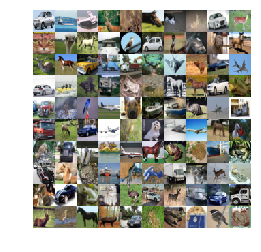

In [6]:
d = CifarDataManager()

print("Number of train images: {}".format(len(d.train.images)))
print("Number of train labels: {}".format(len(d.train.labels)))
print("Number of test images: {}".format(len(d.test.images)))
print("Number of test images: {}".format(len(d.test.labels)))

images = d.train.images
display_cifar(images, 10)

### Simple CIFAR10 Models

#### < Forward Propagation >

In [7]:
def weight_variable(shape):
    """ This specifies the weights for either fully connected or convolutional layers 
       of the network. They are initialized randomly using a truncated normal distribution 
       with a standard deviation of .1. """
    initial = tf.truncated_normal(shape, stddev=0.1) 
    return tf.Variable(initial)

def bias_variable(shape):
    """ This defines the bias elements in either a fully connected or a convolutional layer. 
        These are all initialized with the constant value of .1."""
    initial = tf.constant(0.1, shape=shape) 
    return tf.Variable(initial)

def conv2d(x, W):
    """ This specifies the convolution we will typically use. A full convolution (no skips) 
        with an output the same size as the input."""
    return tf.nn.conv2d(x, W, strides=[1, 1, 1, 1], padding='SAME')

def max_pool_2x2(x):
    """ This sets the max pool to half the size across the height/width dimensions, 
        and in total a quarter the size of the feature map."""
    return tf.nn.max_pool(x, ksize=[1, 2, 2, 1],
                              strides=[1, 2, 2, 1], padding='SAME')

def conv_layer(input, shape):
    """ This is the actual layer we will use. Linear convolution as defined in conv2d, with a bias, 
        followed by the ReLU nonlinearity."""
    W = weight_variable(shape)
    b = bias_variable([shape[3]])
    return tf.nn.relu(conv2d(input, W) + b)

def full_layer(input, size):
    """ A standard full layer with a bias. Notice that here we didn’t add the ReLU. 
        This allows us to use the same layer for the final output, 
        where we don’t need the non‐linear part."""
    in_size = int(input.get_shape()[1]) 
    W = weight_variable([in_size, size]) 
    b = bias_variable([size])
    return tf.matmul(input, W) + b

In [8]:
cifar = CifarDataManager()

x = tf.placeholder(tf.float32, shape=[None, 32, 32, 3])
y_ = tf.placeholder(tf.float32, shape=[None, 10])
keep_prob = tf.placeholder(tf.float32)

conv1 = conv_layer(x, shape=[5, 5, 3, 32])
conv1_pool = max_pool_2x2(conv1)

conv2 = conv_layer(conv1_pool, shape=[5, 5, 32, 64])
conv2_pool = max_pool_2x2(conv2)
conv2_flat = tf.reshape(conv2_pool, [-1, 8 * 8 * 64])

full_1 = tf.nn.relu(full_layer(conv2_flat, 1024))
full1_drop = tf.nn.dropout(full_1, keep_prob=keep_prob)

y_conv = full_layer(full1_drop, 10)

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


#### < Back-propagation >

In [9]:
cross_entropy = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=y_conv,
labels=y_))
train_step = tf.train.AdamOptimizer(1e-3).minimize(cross_entropy)

correct_prediction = tf.equal(tf.argmax(y_conv, 1), tf.argmax(y_, 1))
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

Instructions for updating:

Future major versions of TensorFlow will allow gradients to flow
into the labels input on backprop by default.

See `tf.nn.softmax_cross_entropy_with_logits_v2`.



In [10]:
def test(sess):
    X = cifar.test.images.reshape(10, 1000, 32, 32, 3)
    Y = cifar.test.labels.reshape(10, 1000, 10)
    acc = np.mean([sess.run(accuracy, feed_dict={x: X[i], y_: Y[i],
    keep_prob: 1.0}) for i in range(10)])
    print("Accuracy: {:.4}%".format(acc * 100))

#### Launching the Graph...

In [11]:
STEPS = 10000
BATCH_SIZE = 100

with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    
    for i in range(STEPS):
        batch = cifar.train.next_batch(BATCH_SIZE)
        sess.run(train_step, feed_dict={x: batch[0], y_: batch[1],
        keep_prob: 0.5})
        
        if (i+1)%500 == 0:
            train_accuracy = sess.run(accuracy, 
                                      feed_dict={x: batch[0],         
                                                 y_: batch[1],
                                                 keep_prob: 1.0}) 
            print("[ STEP {} ] :\t Training Accuracy = {:.4}%".format(str(i+1).rjust(5), 
                                                               train_accuracy*100))
    
    test(sess)

[ STEP   500 ] :	 Training Accuracy = 50.0%
[ STEP  1000 ] :	 Training Accuracy = 60.0%
[ STEP  1500 ] :	 Training Accuracy = 71.0%
[ STEP  2000 ] :	 Training Accuracy = 76.0%
[ STEP  2500 ] :	 Training Accuracy = 82.0%
[ STEP  3000 ] :	 Training Accuracy = 93.0%
[ STEP  3500 ] :	 Training Accuracy = 95.0%
[ STEP  4000 ] :	 Training Accuracy = 95.0%
[ STEP  4500 ] :	 Training Accuracy = 98.0%
[ STEP  5000 ] :	 Training Accuracy = 98.0%
[ STEP  5500 ] :	 Training Accuracy = 98.0%
[ STEP  6000 ] :	 Training Accuracy = 97.0%
[ STEP  6500 ] :	 Training Accuracy = 99.0%
[ STEP  7000 ] :	 Training Accuracy = 98.0%
[ STEP  7500 ] :	 Training Accuracy = 100.0%
[ STEP  8000 ] :	 Training Accuracy = 99.0%
[ STEP  8500 ] :	 Training Accuracy = 99.0%
[ STEP  9000 ] :	 Training Accuracy = 100.0%
[ STEP  9500 ] :	 Training Accuracy = 100.0%
[ STEP 10000 ] :	 Training Accuracy = 100.0%
Accuracy: 71.06%
